# Visualize topographic and climatic distributions per land form

In [1]:
import geopandas as gpd
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns

In [2]:
file_path = Path('/Users/wmk934/data/perceptual_models/data/zonal_stats/')
dat_file_name = 'zonal_stats.csv'
shp_file_name = 'merit_hydro_basins_MODIS_IGBP_counts.shp'

In [3]:
dat = pd.read_csv(file_path/dat_file_name)

In [4]:
shp = gpd.read_file(file_path/shp_file_name)

In [5]:
# Merge the whole thing so we can look at geographical locations
dat = dat.set_index('COMID')
shp = shp.set_index('COMID')
assert (dat.index == shp.index).all() # pops an error if index (COMID) order is not the same in both dataframes
dat['geometry'] = shp['geometry']
dat = gpd.GeoDataFrame(dat)

In [19]:
# Drop all the islands etc. for which we're missing data
area = dat[dat.isna().any(axis=1)]['area_km2'].sum()
apct = area / dat['area_km2'].sum()
datc = dat.dropna()
print(f'Dropped {len(dat)-len(datc)} rows, with a total area of {area:0.2} km^2 ({apct:0.2}% of total land mass).')

Dropped 72238 rows, with a total area of 5.8e+05 km^2 (0.027% of total land mass).


In [6]:
# Get some borders for context
border_path = Path('/Users/wmk934/data/Global_geospatial/borders/world-administrative-boundaries')
border_file = 'world-administrative-boundaries.shp'
borders = gpd.read_file(border_path/border_file)

In [7]:
nab = borders[(borders['iso3'] == 'USA') | (borders['iso3'] == 'CAN') | (borders['iso3'] == 'MEX')].copy().reset_index(drop=True)

### Define landforms
Mountains, hills, plateaus, plains

In [8]:
# Image save location
save_path = Path('/Users/wmk934/data/perceptual_models/img')

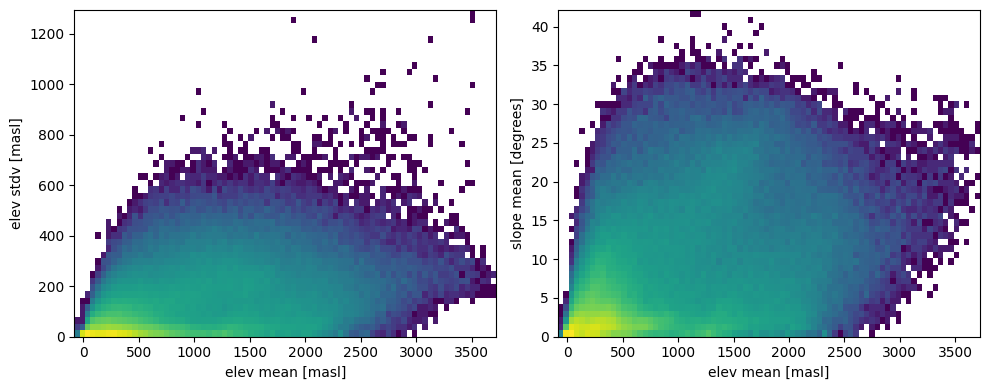

In [28]:
fig,ax = plt.subplots(1,2, figsize=(10,4))

# Original approach
ax[0].hist2d(datc['elev_mean'], datc['elev_stdev'], (80,50), norm = LogNorm());
ax[0].set_xlabel('elev mean [masl]'); ax[0].set_ylabel('elev stdv [masl]')

# New approach
ax[1].hist2d(datc['elev_mean'], datc['slope_mean'], (80,50), norm = LogNorm());
ax[1].set_xlabel('elev mean [masl]'); ax[1].set_ylabel('slope mean [degrees]')

plt.tight_layout()

In [29]:
# Attempt 1
mask_mountain1 = (dat['elev_mean'] >  550) & (dat['elev_stdev'] >  100)
mask_plateau1  = (dat['elev_mean'] >  550) & (dat['elev_stdev'] <= 100)
mask_hill1     = (dat['elev_mean'] <= 550) & (dat['elev_stdev'] >   25)
mask_plain1    = (dat['elev_mean'] <= 550) & (dat['elev_stdev'] <=  25)

In [80]:
# Attempt 2
mask_mountain2 = (dat['elev_mean'] >  550) & (dat['slope_mean'] >  4)
mask_plateau2  = (dat['elev_mean'] >  550) & (dat['slope_mean'] <= 4)
mask_hill2     = (dat['elev_mean'] <= 550) & (dat['slope_mean'] >  2.5)
mask_plain2    = (dat['elev_mean'] <= 550) & (dat['slope_mean'] <= 2.5)

In [81]:
print(f'Mask 1 mountain count = {mask_mountain1.sum()};  Mask 2 mountain count = {mask_mountain2.sum()}')
print(f'Mask 1 plateau  count = {mask_plateau1.sum()};  Mask 2 plateau  count = {mask_plateau2.sum()}')
print(f'Mask 1 hill     count = {mask_hill1.sum()}; Mask 2 hill     count = {mask_hill2.sum()}')
print(f'Mask 1 plain    count = {mask_plain1.sum()}; Mask 2 plain    count = {mask_plain2.sum()}')

Mask 1 mountain count = 82897;  Mask 2 mountain count = 102841
Mask 1 plateau  count = 92881;  Mask 2 plateau  count = 72937
Mask 1 hill     count = 107589; Mask 2 hill     count = 112656
Mask 1 plain    count = 258463; Mask 2 plain    count = 250764


In [82]:
shp = dat[['geometry']].copy()
shp['topo_cat1'] = 0
shp.loc[mask_mountain1, 'topo_cat1'] = 1
shp.loc[mask_plateau1,  'topo_cat1'] = 2
shp.loc[mask_hill1,     'topo_cat1'] = 3
shp.loc[mask_plain1,    'topo_cat1'] = 4
shp['topo_cat2'] = 0
shp.loc[mask_mountain2, 'topo_cat2'] = 1
shp.loc[mask_plateau2,  'topo_cat2'] = 2
shp.loc[mask_hill2,     'topo_cat2'] = 3
shp.loc[mask_plain2,    'topo_cat2'] = 4

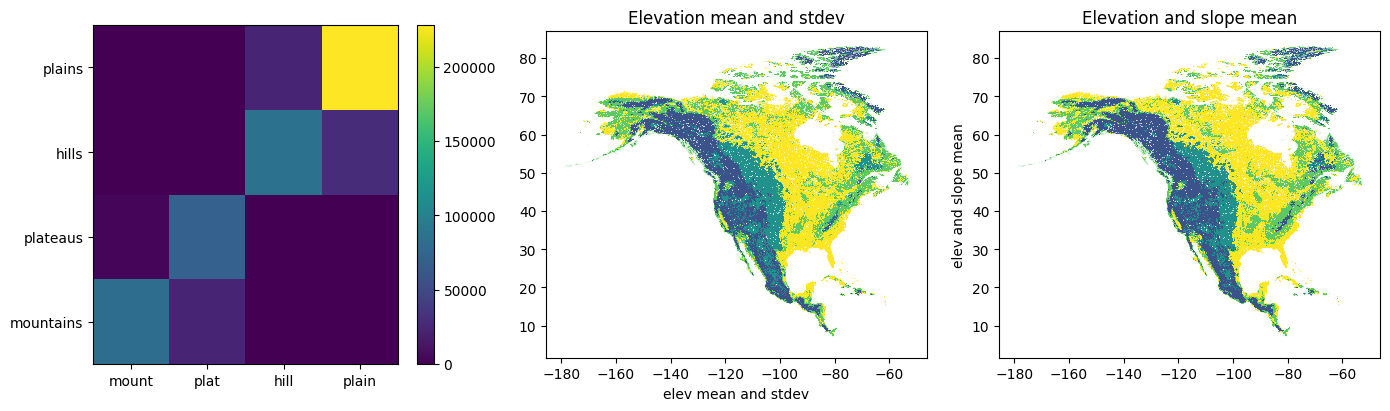

In [83]:
fig,ax = plt.subplots(1,3, figsize=(14,4))

h = ax[0].hist2d(shp['topo_cat1'], shp['topo_cat2'], [0.5,1.5,2.5,3.5,4.5]);
fig.colorbar(h[3],ax=ax[0])
ax[0].set_xticks([1,2,3,4]); ax[0].set_xticklabels(['mount','plat','hill','plain']); ax[1].set_xlabel('elev mean and stdev')
ax[0].set_yticks([1,2,3,4]); ax[0].set_yticklabels(['mountains','plateaus','hills','plains']); ax[2].set_ylabel('elev and slope mean')

shp.plot(column='topo_cat1', ax=ax[1]); ax[1].set_title('Elevation mean and stdev')
shp.plot(column='topo_cat2', ax=ax[2]); ax[2].set_title('Elevation and slope mean')

plt.tight_layout()

### Plot statistics per landform

In [87]:
# Masks
masks     = [mask_mountain2, mask_plateau2, mask_hill2, mask_plain2]
landforms = ['Mountains','Plateaus','Hills','Plains']

In [84]:
# Variables for which we want to plot histograms
variables = ['elev_mean','slope_mean','',
             'im_mean','imr_mean','fs_mean',
             'lgrip','igbp','depth_mean']
variables_leg = ['elevation [m.a.s.l.]','slope [degrees]','',
                 'aridity Im [-]','seasonality Imr [-]','snow fs [-]',
                 'agri class [-]', 'igbp class [-]', 'soil depth [m]']

In [85]:
def plot_categorical_histogram(cat, df, ax, mask, basin):
    '''Converts columns with categorical data counts in a dataframe into a histogram'''
    
    # Define what we're working with
    if cat == 'lgrip':
        columns = ['lg_water', 'lg_non-cro', 'lg_irrigat', 'lg_rainfed']
        labels  = ['Water', 'Non-cropland', 'Irrigated', 'Rain-fed']
        tick_labels = labels # Need this so we can use different ticks for IGBP
        rotation = 35
        align = 'right'
    elif cat == 'igbp':
        columns = ['igbp_1', 'igbp_2', 'igbp_3', 'igbp_4', 'igbp_5',
                   'igbp_6', 'igbp_7', 'igbp_8', 'igbp_9', 'igbp_10', 'igbp_11', 'igbp_12',
                   'igbp_13', 'igbp_14', 'igbp_15', 'igbp_16', 'igbp_17']#, 'igbp_255'] # skip 255 becaue we know we have no 255 values in this dataset
        labels = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17'] #,'255']
        tick_labels = ['1','','3','','5','','7','','9','','11','','13','','15','','17'] # Need to skip half for space reasons
        rotation = 90
        align = 'center'
    else:
        print(f'Cateogry {cat} not defined')
        return

    # Find what we're plotting 
    data_all = {}
    for column,label in zip(columns,labels):
        data_all[label] = df[column].sum()
    data_mask = {}
    for column,label in zip(columns,labels):
        data_mask[label] = df[mask][column].sum()

    # Make the plot
    ax.bar(data_all.keys(),  data_all.values(), width=1, label='all') # width=1 eliminates gaps between bars
    ax.bar(data_mask.keys(), data_mask.values(), width=1,label=basin)
    ax.set_xticks(range(0,len(data_all.keys()))) # Needed because we otherwise get a warning
    ax.set_xticklabels(tick_labels, rotation=rotation, ha=align)

    return ax

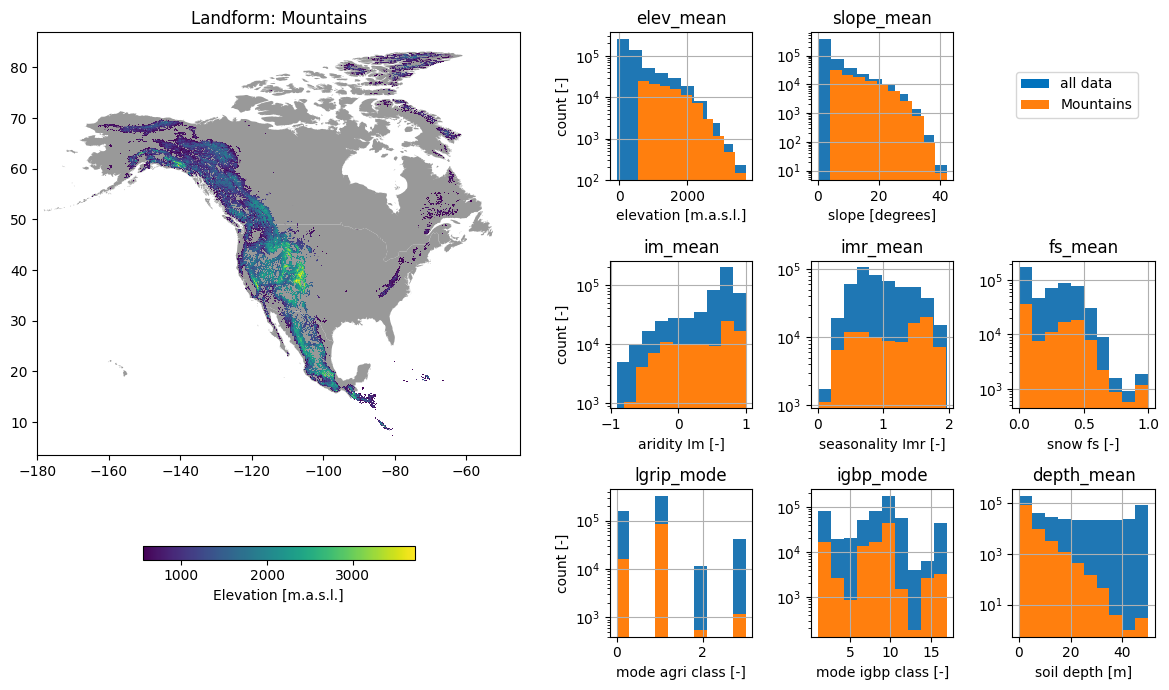

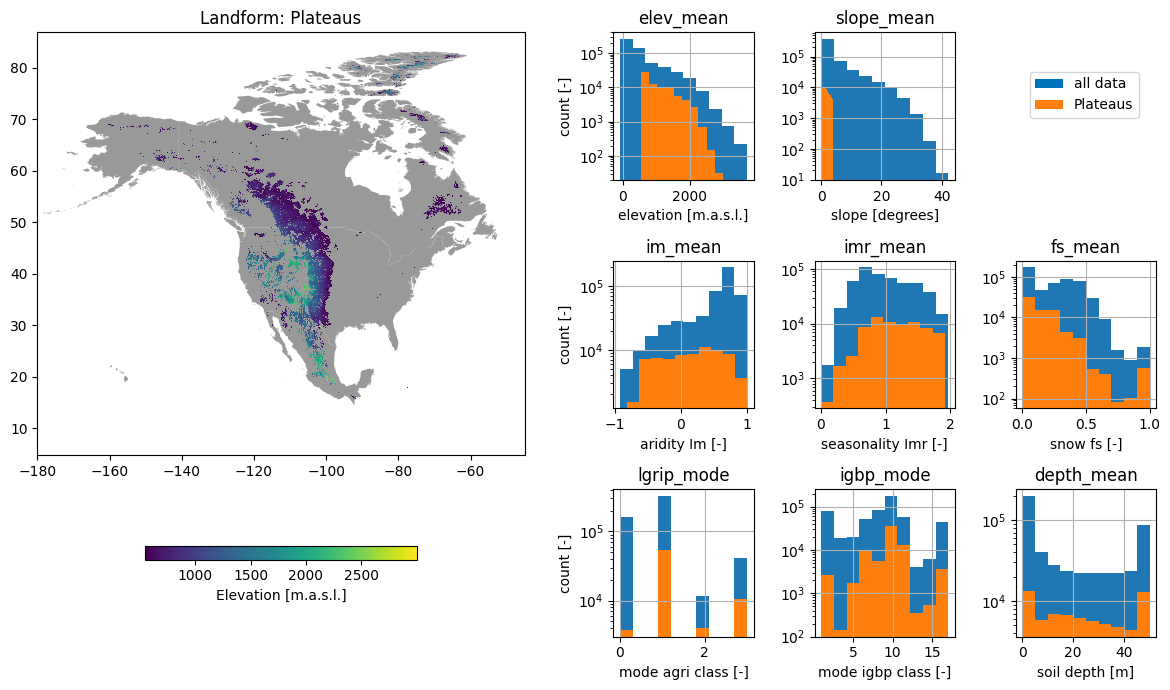

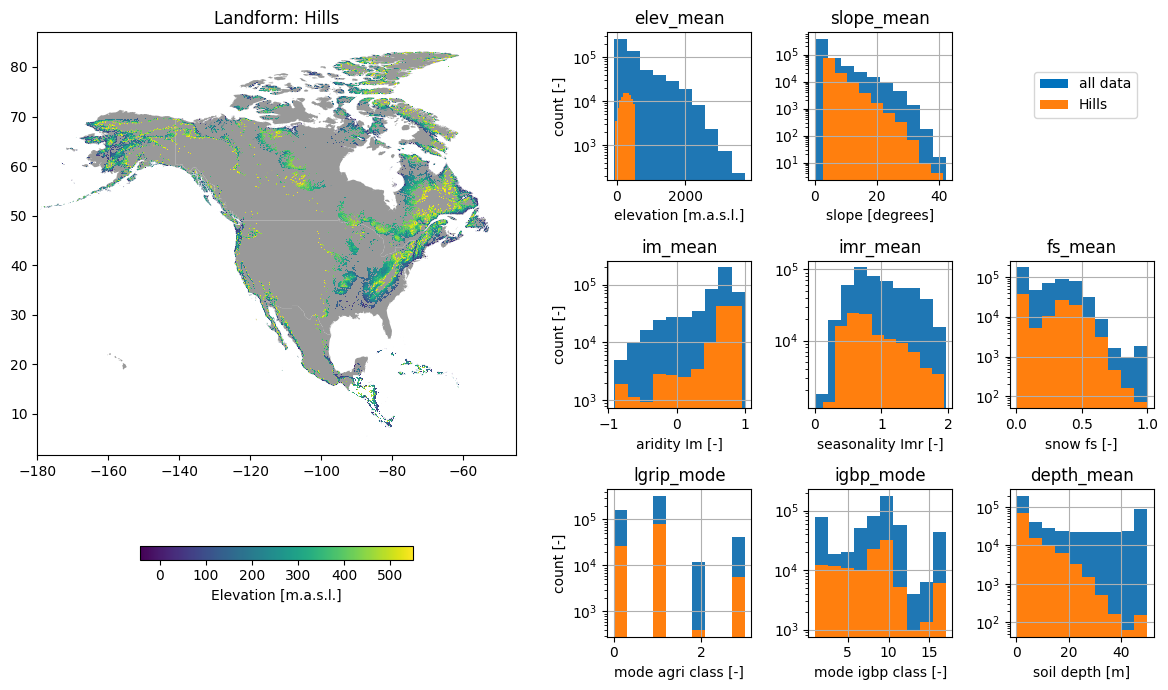

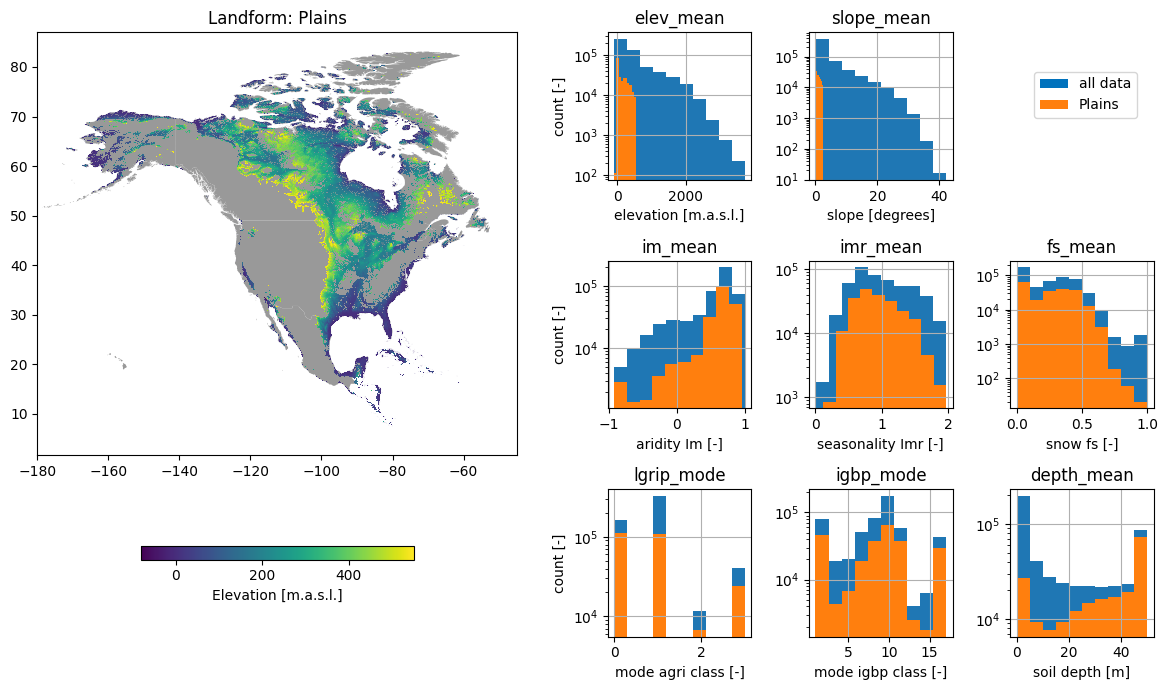

In [111]:
# Loop over the classes and create map + histograms
for mask,landform in zip(masks,landforms):
    
    fig = plt.figure(figsize=(12, 7))

    # Create a large map on the left half
    ax_large = plt.subplot2grid((3, 6), (0, 0), rowspan=3, colspan=3)
    nab.plot(ax=ax_large,color='0.6')
    dat[mask].plot(ax=ax_large, column='elev_mean', legend=True, 
                   legend_kwds={
                       'shrink':.5, 
                       'orientation':'horizontal',
                       'label':'Elevation [m.a.s.l.]'
                   })
    ax_large.set_xlim([-180,-45])
    ax_large.set_title(f'Landform: {landform}')

    # Create smaller histograms on the right half
    ii = [0,0,0,1,1,1,2,2,2]
    jj = [0,1,2,0,1,2,0,1,2]
    for i,j,var,var_lbl in zip(ii,jj,variables,variables_leg):
        ax = plt.subplot2grid((3, 6), (i, j+3))
        if var == '':
                ax.set_visible(False) # No data here, so hide the axis
                continue
        if (var == 'lgrip') or (var == 'igbp'): # Build a histogram for categorical data
            ax = plot_categorical_histogram(var, dat, ax, mask, landform)        
        else:  
            dat[var].hist(ax=ax, label='all')
            dat[mask][var].hist(ax=ax, label=landform)
        
        # Junk
        if j == 0: ax.set_ylabel('count [-]')
        ax.set_yscale('log')
        ax.set_xlabel(var_lbl)
        ax.set_title(f'{var}')
    
    # Create custom legend elements
    legend_elements = [
        Patch(facecolor=[0, 0.447, 0.741], edgecolor='None', label='all data'),
        Patch(facecolor=[1.0, 0.49803922, 0.05490196], edgecolor='None', label=f'{landform}')
    ]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.975, 0.90))
    
    plt.tight_layout()
    plt.savefig(save_path / f'descriptors_by_landform_{landform}.png', dpi=300, bbox_inches='tight')

## Individual investigations
### General functions

In [106]:
variables = ['elev_mean','slope_mean','',
             'im_mean','imr_mean','fs_mean',
             'lgrip_mode','igbp_mode','depth_mean']
variables_leg = ['elevation [m.a.s.l.]','slope [degrees]','',
                 'aridity Im [-]','seasonality Imr [-]','snow fs [-]',
                 'mode agri class [-]', 'mode igbp class [-]', 'soil depth [m]']
cmaps = ['Purples_r','YlGn_r','',
         'Reds_r','Greens','Blues',
         'tab10','tab20b','YlOrBr']

In [109]:
def make_stat_per_landform_plots(df,mask,variables,variables_leg,cmaps,landform,background,save_path):

    '''Plots 8 maps'''
   
    fig,axs = plt.subplots(3,3,figsize=(15, 15))
    
    ii = [0,0,0,1,1,1,2,2,2]
    jj = [0,1,2,0,1,2,0,1,2]
    for i,j,var,var_lbl,cmap in zip(ii,jj,variables,variables_leg,cmaps):
        ax = axs[i,j]
        if var == '':
            ax.set_visible(False) # No data here, so hide the axis
            continue

        background.plot(ax=ax,color='0.6')
        df[mask].plot(ax=ax, column=var, legend=True, cmap=cmap, 
                   legend_kwds={
                       'shrink':.5, 
                       'orientation':'horizontal',
                       'label':var_lbl
                   })
        ax.set_xlim([-180,-45])

    fig.suptitle(f'Landform: {landform}')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return 

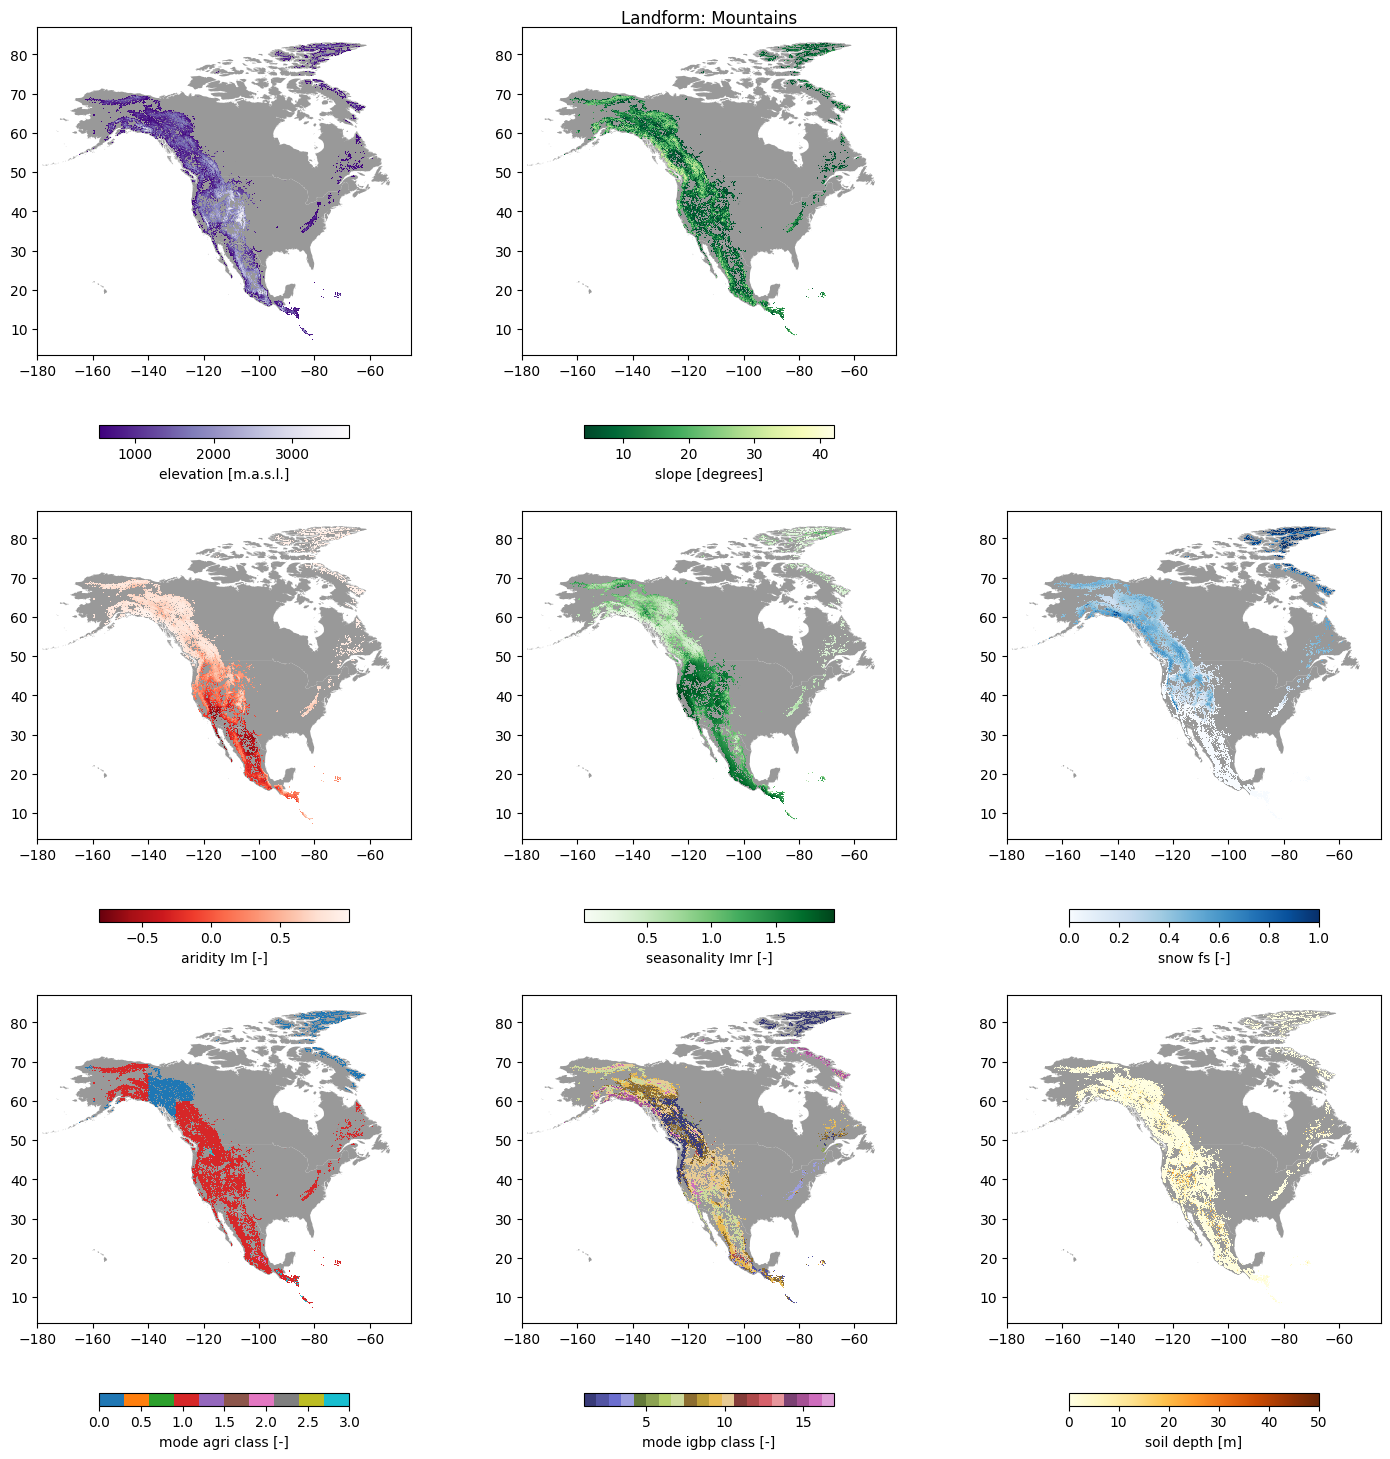

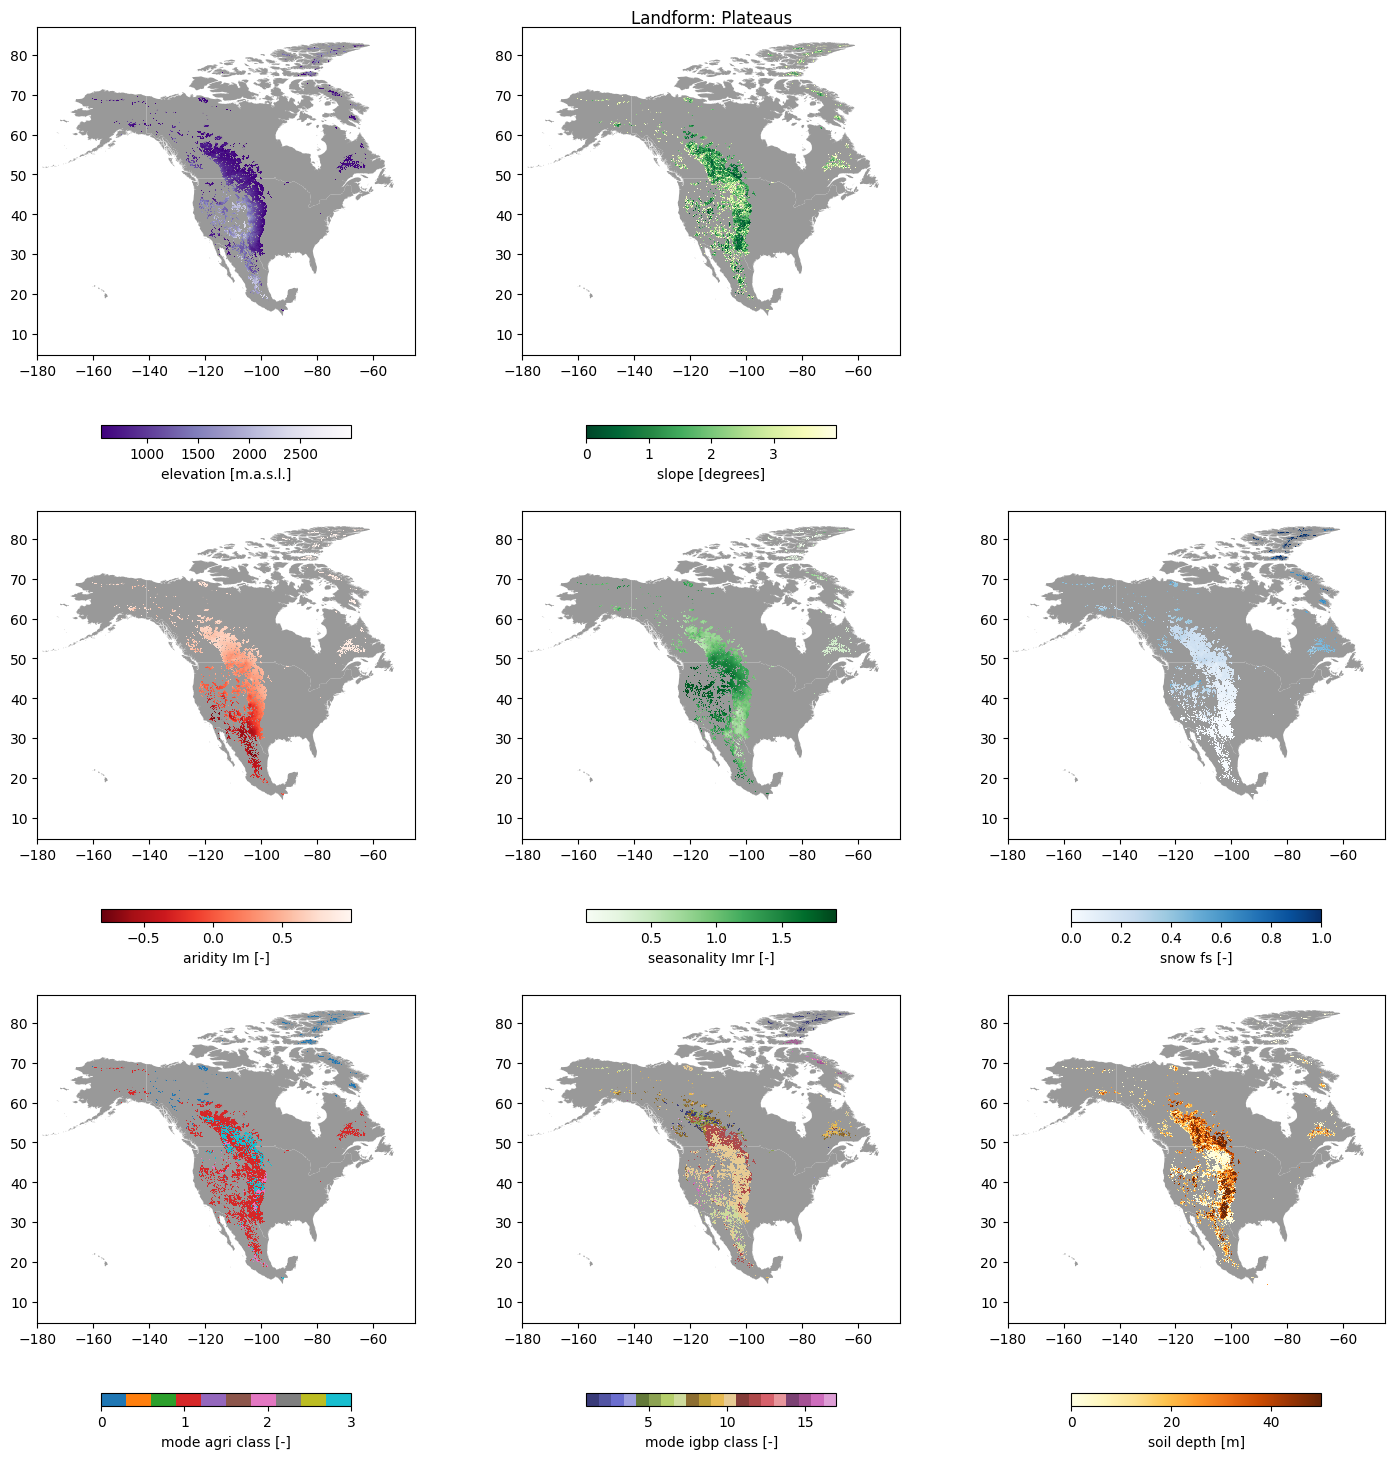

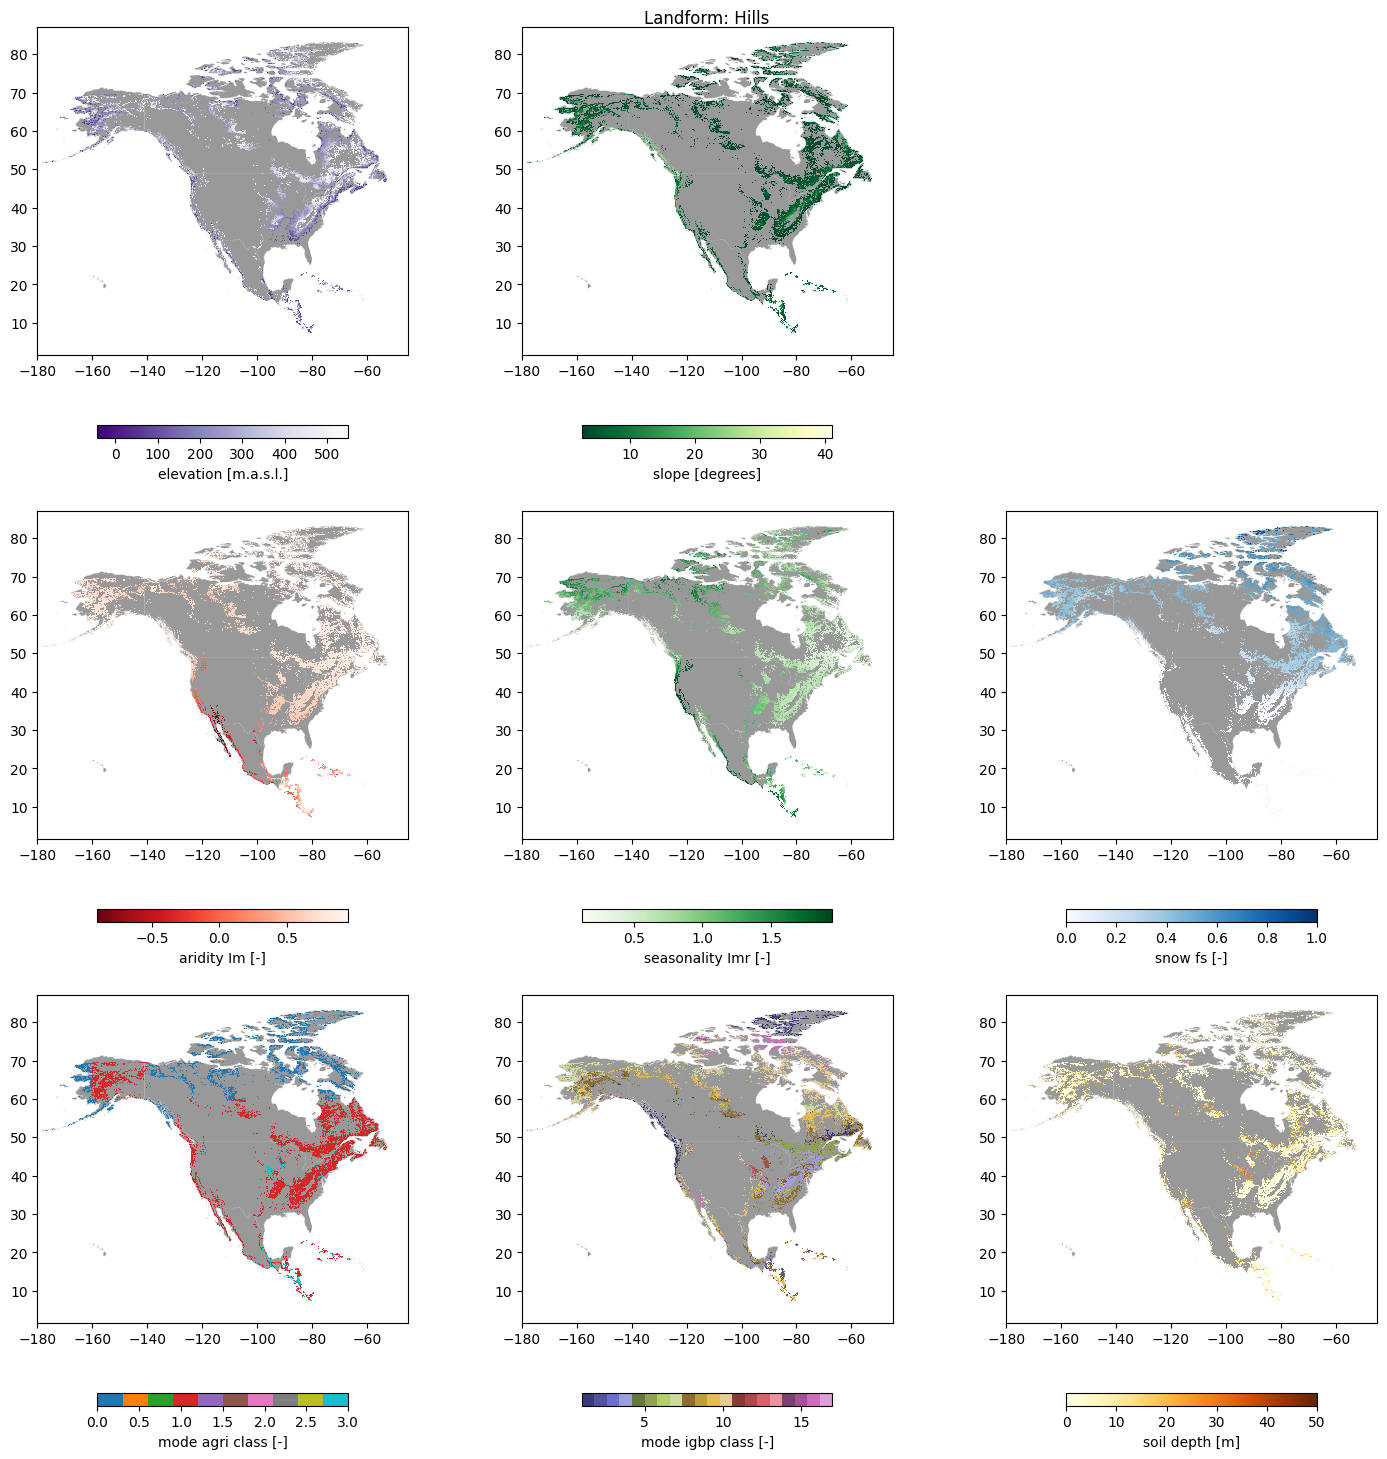

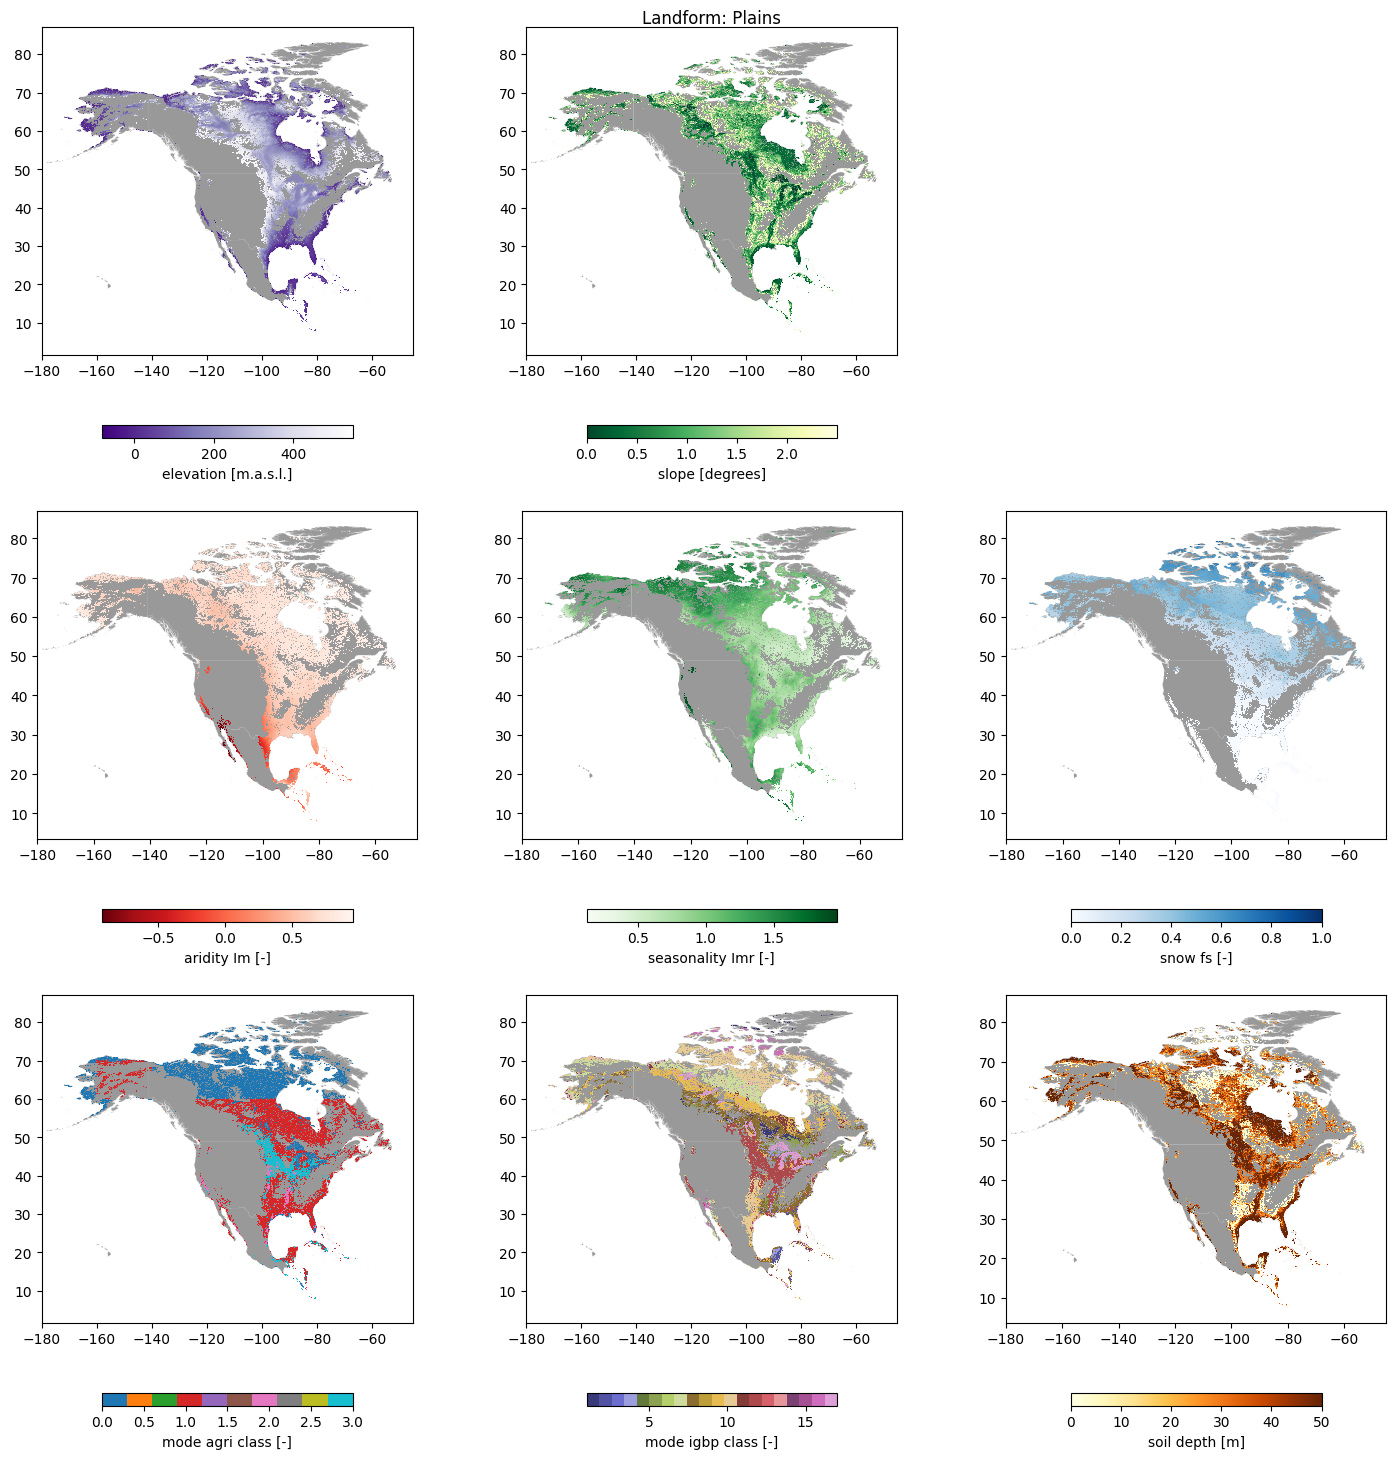

In [112]:
for mask,landform in zip(masks,landforms):
    save_here = save_path / f'maps_by_landform_{landform}.png'
    make_stat_per_landform_plots(dat, mask, variables, variables_leg, cmaps, landform, nab, save_here);